In [36]:
import numpy as np

path = 'output_vlm_both/'
# read npz file
npzfile = np.load(f'{path}sample_1.npz')
npzfile

NpzFile 'output_vlm_both/sample_1.npz' with keys: sae_acts, hidden_state

In [37]:
npzfile['hidden_state'].shape

(576, 2048)

In [38]:
npzfile['sae_acts'].shape

(1, 576, 16384)

In [ ]:
npzfile['hidden_state'][:]

In [1]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch

model_id = "google/paligemma-3b-mix-224"
device = "cuda:0"
dtype = torch.bfloat16

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval()
processor = AutoProcessor.from_pretrained(model_id)

# Instruct the model to create a caption in Spanish
prompt = "caption es"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)


/home/shan/mambaforge/envs/opencompass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Un auto azul estacionado frente a un edificio.


In [6]:
# count the number 257152 in tensor
# tensor = torch.tensor([257152, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print((tensor == 257152).sum().item())

(model_inputs['input_ids']== 257152).sum().item()

256

In [1]:
import torch
from datasets import load_dataset
from functions import load_models_and_processor, prepare_image_inputs, generate_text

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# Global configurations
checkpoint = "Intel/llava-gemma-2b"

/home/shan/mambaforge/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
from collections import Counter
import pandas as pd

df_name = 'results/imagenet-1k-256x256_gemma-2b-it_layer12.csv'
# df_name = 'results/cifar100-enriched_gemma-2b_layer12.csv'
dataset = df_name.split('/')[1].split('_gemma')[0]
layer = df_name.split('layer')[1].split('.csv')[0]
release = df_name.split('/')[1].split('_')[1].split('_layer')[0]
if 'imagenet' in dataset:
    num_classes = 1000
    ds =  "benjamin-paine/imagenet-1k-256x256"
else:
    num_classes = 100
    ds = "renumics/cifar100-enriched"

df = pd.read_csv(df_name)

In [3]:
if ds == "benjamin-paine/imagenet-1k-256x256":
    dataset = load_dataset(ds, split='validation')
else:
    dataset = load_dataset(ds, split='test')
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 50000
})

In [4]:
checkpoint = "Intel/llava-gemma-2b"
model, processor, sae = load_models_and_processor(checkpoint, layer, release, device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 10.26it/s]


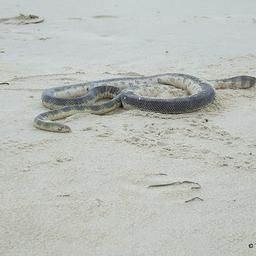

In [5]:
image = dataset['image'][0]
image

In [6]:
prompt = processor.tokenizer.apply_chat_template(
            [{'role': 'user', 'content': "<image>"}],
            tokenize=False,
            add_generation_prompt=True
        )
inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True).to(device)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


In [7]:
inputs['input_ids']

tensor([[     2,      2,    106,   1645,    108, 256000,    107,    108,    106,
           2516,    108]], device='cuda:0')

In [ ]:
# i used these visual tokens to activate gemma-2b or gemma-2b-it's sae. and got meaning representations.
# what i want to try now: use these hidden states to generate text based on gemma-2b or gemma-2b-it's sae.

In [ ]:
# TODO: Add the code to generate the text for the image based on gemma_it_layer12